# SVM -> Best LogLoss = 
## Using only seeding for now ##

The original inspiration for this notebook was drawn from the Basic Starter Kernel NCAA Men's Datase on Kaggle by Julia Elliot https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-men-s-dataset

In [5]:
import numpy as np 
import pandas as pd 
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../NCAA"]).decode("utf8"))

# Any results you write to the current directory are saved as output.


BasicKaggleKernel.ipynb
Cities.csv
Conferences.csv
ConferenceTourneyGames.csv
GameCities.csv
MasseyOrdinals.csv
MLP_first_go.csv
NCAATourneyCompactResults.csv
NCAATourneyDetailedResults.csv
NCAATourneySeedRoundSlots.csv
NCAATourneySeeds.csv
NCAATourneySlots.csv
RegularSeasonCompactResults.csv
RegularSeasonDetailedResults.csv
SampleSubmissionStage1.csv
Seasons.csv
SecondaryTourneyCompactResults.csv
SecondaryTourneyTeams.csv
SKLearn - MLP.ipynb
SKLearn - SVM.ipynb
TeamCoaches.csv
TeamConferences.csv
Teams.csv
TeamSpellings.csv



## Load the training data ##
We're keeping it simple & using only 2 files for this model: the Tourney seeds & Compact results.

In [6]:
data_dir = '../NCAA/'
df_seeds = pd.read_csv(data_dir + 'NCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')

In [7]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [8]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


First, we'll simplify the datasets to remove the columns we won't be using and convert the seedings to the needed format (stripping the regional abbreviation in front of the seed).

In [9]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(columns=['Seed'], inplace=True) # This is the string label
df_seeds.head()

,Season,TeamID,seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [10]:
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


## Merge seed for each team ##
Merge the Seeds with their corresponding TeamIDs in the compact results dataframe.

In [11]:
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_winseeds.head()

,Season,WTeamID,WSeed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [12]:
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_dummy.head()

,Season,WTeamID,LTeamID,WSeed
0,1985,1116,1234,9
1,1985,1120,1345,11
2,1985,1207,1250,1
3,1985,1229,1425,9
4,1985,1242,1325,3


In [13]:
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


Now we'll create a dataframe that summarizes wins & losses along with their corresponding seed differences. This is the meat of what we'll be creating our model on.

In [14]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


In [15]:
X_train = df_predictions.SeedDiff.values.reshape(-1,1)
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)

## Train the model ##
Use an SVM network to train the model. 

In [17]:
clf = SVC(C = 1, kernel = 'rbf', probability = True)
# clf = GridSearchCV(svm, param_grid={
#     'kernel': ['linear', 'poly', 'rbf'],
#     'C': [1, 3, 9]},
#      scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
# print("Training set score: %f" % clf.best_score_)
print("Training set score: %f" % clf.score(X_train, y_train))

Training set score: 0.712565


Text(0,0.5,'P(Team1 will win)')

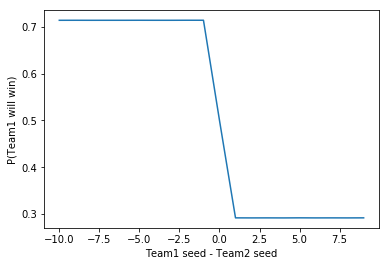

In [25]:
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

Plotting validates our intuition, that the probability a team will win decreases as the seed differential to its opponent decreases.

In [26]:
df_sample_sub = pd.read_csv(data_dir + 'SampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

In [27]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

## Make Predictions ##
Create predictions using the logistic regression model we trained.

In [28]:
preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

,ID,Pred
0,2014_1107_1110,0.291910
1,2014_1107_1112,0.291824
2,2014_1107_1113,0.291823
3,2014_1107_1124,0.291883
4,2014_1107_1140,0.291823


Lastly, create your submission file!

In [29]:
df_sample_sub.to_csv('SVM_first_go.csv', index=False)